In [2]:
# Set local python and nltk paths
import sys
sys.path.insert(0,'/vol/medic02/users/ag6516/miniconda/envs/TheanoLasagne/lib/python2.7/site-packages')
sys.path.insert(0,'/vol/medic02/users/ag6516/miniconda/envs/TheanoLasagne/lib/python2.7/site-packages/setuptools-27.2.0-py2.7.egg')
sys.path.insert(0,'/vol/medic02/users/ag6516/miniconda/envs/TheanoLasagne/lib/python2.7/site-packages/IPython/extensions')
sys.path
import nltk
nltk.data.path = ['/vol/medic02/users/ag6516/nltk_data']

In [3]:
%matplotlib inline

import os
import csv
import json
import pickle
import pandas as pd

import sklearn
from sklearn import model_selection
from sklearn.decomposition import PCA
import numpy as np
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import random
from random import randint
random.seed(123)
np.random.seed(123)

import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

import torch

# Set THEANO_FLAGS='device=cuda0,floatX=float32' to run notebook on gpu
import lasagne
from lasagne.utils import floatX
import theano
import theano.tensor as T
from collections import Counter
from lasagne.utils import floatX

import googlenet

from read_data import read_csv_into_df
from vis_utils import kmeans_clustering, plot_pca, visualise_word_clusters2, kmeans_silhouette
from vis_utils import save_clusters_to_json, load_clusters_from_json

ERROR (theano.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "/vol/medic02/users/ag6516/miniconda/envs/TheanoLasagne/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 164, in <module>
    use(config.device)
  File "/vol/medic02/users/ag6516/miniconda/envs/TheanoLasagne/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 151, in use
    init_dev(device)
  File "/vol/medic02/users/ag6516/miniconda/envs/TheanoLasagne/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 66, in init_dev
    avail = dnn.dnn_available(name)
  File "/vol/medic02/users/ag6516/miniconda/envs/TheanoLasagne/lib/python2.7/site-packages/theano/gpuarray/dnn.py", line 174, in dnn_available
    if not dnn_present():
  File "/vol/medic02/users/ag6516/miniconda/envs/TheanoLasagne/lib/python2.7/site-packages/theano/gpuarray/dnn.py", line 157, in dnn_present
    dnn_present.avail, dnn_present.msg = _dnn_check_version()
  File "/vol/medic02

In [8]:
dir = ('/vol/medic02/users/ag6516/x_ray_fracture_localisation/')
# dir = ('/Users/Aydan/PhD/x_ray_fracture_localisation/')

# LSTM Model - Baseline

In [137]:
dataset = pickle.load(open('sample_images_baseline.pkl'))

In [138]:
d = pickle.load(open(os.path.join('trained_models', 'baseline_trained_v_107.pkl')))
vocab = d['vocab']
word_to_index = d['word_to_index']
index_to_word = d['index_to_word']

In [139]:
# Returns a list of tuples (cnn features, list of words, image ID)
def get_data_batch(dataset, size, split='train'):
    items = []
    
    while len(items) < size:
        item = random.choice(dataset)
        if item['split'] != split:
            continue
        sentence = item['tokens']
        if len(sentence) > MAX_SENTENCE_LENGTH:
            sentence = sentence[1:MAX_SENTENCE_LENGTH]
            #continue
        items.append((item['cnn features'], sentence, item['imid']))
    
    return items

# Convert a list of tuples into arrays that can be fed into the network
def prep_batch_for_network(batch):
    x_cnn = floatX(np.zeros((len(batch), 1000)))
    x_sentence = np.zeros((len(batch), SEQUENCE_LENGTH - 1), dtype='int32')
    y_sentence = np.zeros((len(batch), SEQUENCE_LENGTH), dtype='int32')
    mask = np.zeros((len(batch), SEQUENCE_LENGTH), dtype='bool')

    for j, (cnn_features, sentence, _) in enumerate(batch):
        x_cnn[j] = cnn_features
        i = 0
        for word in ['#START#'] + sentence + ['#END#']:
            if word in word_to_index:
                mask[j, i] = True
                y_sentence[j, i] = word_to_index[word]
                x_sentence[j, i] = word_to_index[word]
                i += 1
        #mask[j, 0] = False
                
    return x_cnn, x_sentence, y_sentence, mask

In [140]:
SEQUENCE_LENGTH = 33
MAX_SENTENCE_LENGTH = SEQUENCE_LENGTH - 3 # 1 for image, 1 for start token, 1 for end token
#BATCH_SIZE = 50
BATCH_SIZE = 1
CNN_FEATURE_SIZE = 1024
EMBEDDING_SIZE = 256

In [141]:
# sentence embedding maps integer sequence with dim (BATCH_SIZE, SEQUENCE_LENGTH - 1) to 
# (BATCH_SIZE, SEQUENCE_LENGTH-1, EMBEDDING_SIZE)
l_input_sentence = lasagne.layers.InputLayer((BATCH_SIZE, SEQUENCE_LENGTH - 1))
l_sentence_embedding = lasagne.layers.EmbeddingLayer(l_input_sentence,
                                                     input_size=len(vocab),
                                                     output_size=EMBEDDING_SIZE,
                                                    )

# cnn embedding changes the dimensionality of the representation from 1000 to EMBEDDING_SIZE, 
# and reshapes to add the time dimension - final dim (BATCH_SIZE, 1, EMBEDDING_SIZE)
l_input_cnn = lasagne.layers.InputLayer((BATCH_SIZE, CNN_FEATURE_SIZE))
l_cnn_embedding = lasagne.layers.DenseLayer(l_input_cnn, num_units=EMBEDDING_SIZE,
                                            nonlinearity=lasagne.nonlinearities.identity)

l_cnn_embedding = lasagne.layers.ReshapeLayer(l_cnn_embedding, ([0], 1, [1]))

# the two are concatenated to form the RNN input with dim (BATCH_SIZE, SEQUENCE_LENGTH, EMBEDDING_SIZE)
l_rnn_input = lasagne.layers.ConcatLayer([l_cnn_embedding, l_sentence_embedding])


l_dropout_input = lasagne.layers.DropoutLayer(l_rnn_input, p=0.5)
l_lstm = lasagne.layers.LSTMLayer(l_dropout_input,
                                  num_units=EMBEDDING_SIZE,
                                  unroll_scan=True,
                                  grad_clipping=5.)
l_dropout_output = lasagne.layers.DropoutLayer(l_lstm, p=0.5)

# the RNN output is reshaped to combine the batch and time dimensions
# dim (BATCH_SIZE * SEQUENCE_LENGTH, EMBEDDING_SIZE)
l_shp = lasagne.layers.ReshapeLayer(l_dropout_output, (-1, EMBEDDING_SIZE))

# decoder is a fully connected layer with one output unit for each word in the vocabulary
l_decoder = lasagne.layers.DenseLayer(l_shp, num_units=len(vocab), nonlinearity=lasagne.nonlinearities.softmax)

# finally, the separation between batch and time dimension is restored
l_out = lasagne.layers.ReshapeLayer(l_decoder, (BATCH_SIZE, SEQUENCE_LENGTH, len(vocab)))

In [142]:
lasagne.layers.set_all_param_values(l_out, d['param values'])

In [143]:
# cnn feature vector
x_cnn_sym = T.matrix()

# sentence encoded as sequence of integer word tokens
x_sentence_sym = T.imatrix()

output = lasagne.layers.get_output(l_out, {
                l_input_sentence: x_sentence_sym,
                l_input_cnn: x_cnn_sym
                })

f = theano.function([x_cnn_sym, x_sentence_sym], output)

In [144]:
# Returns a list of tuples (cnn features, list of words, image ID)
def get_test_set(dataset):
    items = []
    for item in dataset:
        if item['split'] != 'test':
            continue
        sentence = [word for word in item['tokens'] if word in vocab]
        items.append((item['cnn features'], sentence, item['impath']))
    
    return items

In [145]:
test_exams = get_test_set(dataset)
print len(test_exams)

287


In [146]:
allwords = []
pids = set()
for _, sentence, _ in test_exams:
    for word in sentence:
        allwords.append(word)

len(set(allwords))

105

In [147]:
def predict(x_cnn):
    x_sentence = np.zeros((BATCH_SIZE, SEQUENCE_LENGTH - 1), dtype='int32')
    words = []
    i = 0
    while True:
        i += 1
        p0 = f(x_cnn, x_sentence)
        pa = p0.argmax(-1)
        tok = pa[0][i]
        word = index_to_word[tok]
        if word == '#END#' or i >= SEQUENCE_LENGTH - 1:
            return ' '.join(words)
        else:
            x_sentence[0][i] = tok
            if word != '#START#':
                words.append(word)

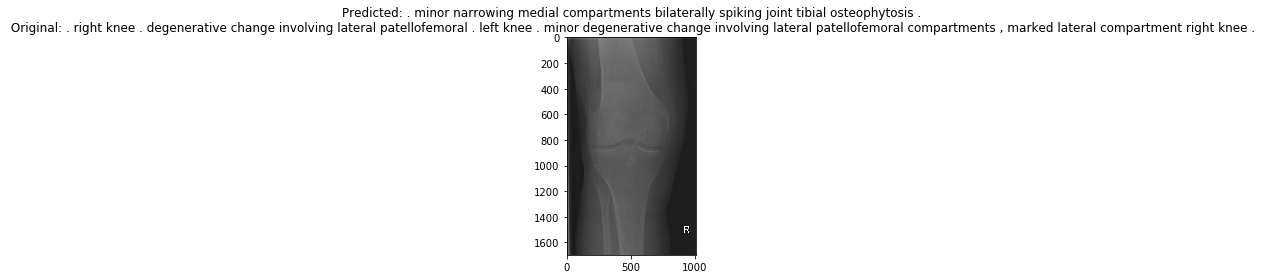

In [148]:
# Sample some predictions
for cnn_features, sentence, impath in random.sample(test_exams,1):
    predictions = []
    for _ in range(1):
        predictions.append(predict(cnn_features))
    plt.figure()
    im = plt.imread(dir+'data/Images/'+impath)
    plt.imshow(im)
    plt.title("Predicted: " + " ".join(predictions) + "\n Original: " + ' '.join(sentence))

## BLEU Evaluation

Calculate modified ngram precision.

The normal precision method may lead to some wrong translations with high-precision, e.g., the translation, in which a word of reference repeats several times, has very high precision.

This function only returns the Fraction object that contains the numerator and denominator necessary to calculate the corpus-level precision.

In [44]:
from nltk.translate.bleu_score import modified_precision

In [149]:
all_test_scores = []
for cnn_features, sentence, impath in test_exams:
    prediction = predict(cnn_features)
    scores = []
    for n in range(4):
        score = modified_precision(sentence, prediction, n)
        scores.append(float(score))
    #print 'Predicted: ', ' '.join(predictions)
    #print 'Original: ', ' '.join(sentence)
    #print 'Scores: ', scores
    all_test_scores.append(scores)

In [150]:
all_test_scores = np.asarray(all_test_scores)

for n in range(4):
    print 'Average BLEU{} score: {}'.format(n+1, np.mean(all_test_scores[:,n]))
    print 'STD: ', np.std(all_test_scores[:,n])

Average BLEU1 score: 0.275778073143
STD:  0.108727070294
Average BLEU2 score: 0.275778073143
STD:  0.108727070294
Average BLEU3 score: 0.276955236813
STD:  0.141647225622
Average BLEU4 score: 0.211583128617
STD:  0.148767079612


## LSTM Model - Max Pooling

In [151]:
dataset = pickle.load(open('sample_exams_cnn_pooled_features.pkl'))

In [152]:
d = pickle.load(open(os.path.join('trained_models', 'maxpooling_trained_v_107.pkl')))
vocab = d['vocab']
word_to_index = d['word_to_index']
index_to_word = d['index_to_word']
lasagne.layers.set_all_param_values(l_out, d['param values'])

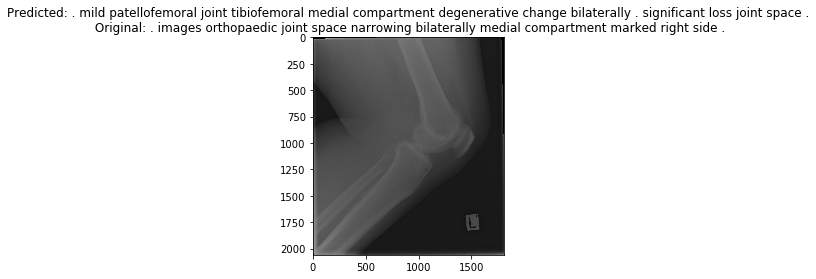

In [153]:
# Sample some predictions
for cnn_features, sentence, impath in random.sample(test_exams,1):
    predictions = []
    for _ in range(1):
        predictions.append(predict(cnn_features))
    plt.figure()
    im = plt.imread(dir+'data/Images/'+impath)
    plt.imshow(im)
    plt.title("Predicted: " + " ".join(predictions) + "\n Original: " + ' '.join(sentence))

In [154]:
all_test_scores = []
for cnn_features, sentence, impath in test_exams:
    prediction = predict(cnn_features)
    scores = []
    for n in range(4):
        score = modified_precision(sentence, prediction, n)
        scores.append(float(score))
    #print 'Predicted: ', ' '.join(predictions)
    #print 'Original: ', ' '.join(sentence)
    #print 'Scores: ', scores
    all_test_scores.append(scores)

In [155]:
all_test_scores = np.asarray(all_test_scores)

for n in range(4):
    print 'Average BLEU{} score: {}'.format(n+1, np.mean(all_test_scores[:,n]))
    print 'STD: ', np.std(all_test_scores[:,n])

Average BLEU1 score: 0.270709668283
STD:  0.0878331646187
Average BLEU2 score: 0.270709668283
STD:  0.0878331646187
Average BLEU3 score: 0.281357258269
STD:  0.125399442347
Average BLEU4 score: 0.207679987649
STD:  0.137668352905
